In [1]:
import os
import time

import multiprocessing as mp

#locationPrefix = "/home/tfuser/programming"
locationPrefix = "/mnt/dropsite"
#locationPrefix = "/mnt/c/Users/Zadran_Ghazohod/OneDrive"
#locationPrefix = "/mnt/c/Users/tfUser/OneDrive"
homeLocation = os.getcwd()
libsLocation = os.path.join(locationPrefix, "gdrove", "tf")


os.chdir(libsLocation)
import tsp.tsp_proc as tsp
import all_aux as au
os.chdir(homeLocation)


print("Ok!")

Ok!


In [9]:
'''
MLPC, 13 towns, 14 procs: Ok! Total count: 239,500,800. Time taken: 106.48 sec.
MLPC, 14 towns, 14 procs: Ok! Total count: 3,113,510,400. Time taken: 1339.78 sec.
MLPC, 15 towns, 22 procs: Ok! Total count: 43,589,145,600. Time taken: 17702.65 sec.

HSCH, 13 towns, 10 procs: Ok! Total count: 239,500,800. Time taken: 149.67 sec.
HSCH, 13 towns, 14 procs: Ok! Total count: 239,500,800. Time taken: 121.86 sec.
HSCH, 14 towns, 14 procs: Ok! Total count: 3,113,510,400. Time taken: 1692.29 sec.

DLNB, 12 towns, 3 procs:  Ok! Total count: 19,958,400. Time taken: 67.81 sec.
DLNB, 13 towns, 3 procs:  Ok! Total count: 239,500,800. Time taken: 869.20 sec.

CAVL, 12 towns, 6 procs:  Ok! Total count: 19,958,400. Time taken: 21.75 sec.
CAVL, 13 towns, 6 procs:  Ok! Total count: 239,500,800. Time taken: 276.33 sec.
CAVL, 14 towns, 6 procs:  Ok! Total count: 3,113,510,400. Time taken: 3838.15 sec.
'''

## INPUTS
numTowns = 14
headSize = 2
numWorkers = 6

print("Ok!")

Ok!


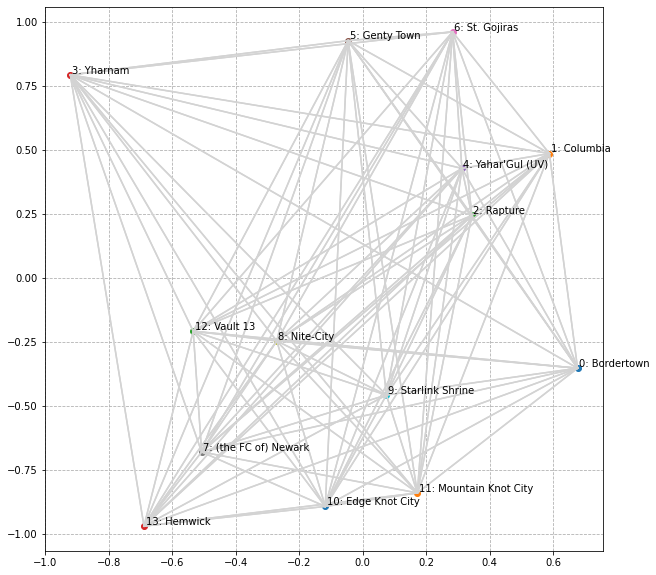

In [10]:
'''

'''

idlessTowns = tsp.generateTowns(n=numTowns)
townIds = list(range(len(idlessTowns)))
xs = [t[1][0] for t in idlessTowns]
ys = [t[1][1] for t in idlessTowns]

towns = [(i,)+town for i,town in zip(townIds, idlessTowns)]
tsp.plotTowns(towns)

In [11]:
timeStart = time.time()

numRoutes = tsp.phuc(len(townIds)-1) // 2
print("HST: Expected usefull routes count: {}".format(numRoutes))

heads = tsp.headsFn(townIds, headSize=headSize)
heads = tsp.startEndShuffle(heads)
batches = tsp.batchList(heads, numBatches=numWorkers)

distMatrix = tsp.xyDistMatrix(xs, ys)

print("HST: creating workers")
quesToCnt = [mp.Queue() for _ in range(numWorkers)]
queToHost = mp.Queue()

workers = [mp.Process(target=tsp.cntWorkerFn(no, townIds, distMatrix, name="countFn_{}".format(no)),
                      args=(queToCnt, queToHost)) \
           for no,queToCnt in enumerate(quesToCnt)]

for worker in workers:
    worker.start()
    
for queToCnt,batch in zip(quesToCnt, batches):
    queToCnt.put(tsp.LoadMsg(load=batch))
    
numRunningWorkers = numWorkers
candidates = []
currentRoutesCount = 0
running = True
while running:
    msg = queToHost.get()
    
    if isinstance(msg, tsp.PoisonMsg):
        numRunningWorkers -= 1
        if numRunningWorkers < 1:
            running = False
            
    elif isinstance(msg, tsp.InfoMsg):
        info = msg.info
        if isinstance(info, dict):
            if info["summary"] == "Routes Count Report":
                currentRoutesCount += info["count"]
                print("HST: Current routes count: {} / {}".format(currentRoutesCount, numRoutes))
                
            elif info["summary"] == "Something Else":
                pass
            
            else:
                print("HST: Strange info message recieved")
        
        else:
            print(info)
        
    elif isinstance(msg, tsp.LoadMsg):
        candidates += [msg.load]
        
    else:
        print("HST: recieved a message of unknown purpose")
        
for queToCnt in quesToCnt:
    queToCnt.put(tsp.PoisonMsg())
    
for worker in workers:
    worker.join()
    
for que in quesToCnt:
    que.close()
        
minRoute = None
minDistance = 999.0
totalCount = 0
for c in candidates:
    if c[1] < minDistance:
        minRoute = c[0]
        minDistance = c[1]
    totalCount += c[2]
        
print("{} ==> {}".format(minRoute, minDistance))

timeTaken = time.time() - timeStart
print("Ok! Total count: {}. Time taken: {} sec.".format(totalCount, "%.2f"%timeTaken))

HST: Expected usefull routes count: 3113510400
HST: creating workers
CNT0: starting...
CNT1: starting...
CNT2: starting...
CNT3: starting...
CNT4: starting...
CNT0: heads recieved: (1, 2)...
CNT1: heads recieved: (2, 1)...
CNT3: heads recieved: (4, 1)...
CNT4: heads recieved: (5, 1)...
CNT2: heads recieved: (3, 1)...
CNT5: starting...
CNT5: heads recieved: (6, 1)...
HST: Current routes count: 25401600 / 3113510400
HST: Current routes count: 54432000 / 3113510400
HST: Current routes count: 87091200 / 3113510400
HST: Current routes count: 123379200 / 3113510400
HST: Current routes count: 163296000 / 3113510400
HST: Current routes count: 203212800 / 3113510400
HST: Current routes count: 203212800 / 3113510400
HST: Current routes count: 221356800 / 3113510400
HST: Current routes count: 235872000 / 3113510400
HST: Current routes count: 239500800 / 3113510400
HST: Current routes count: 250387200 / 3113510400
HST: Current routes count: 257644800 / 3113510400
HST: Current routes count: 2830464

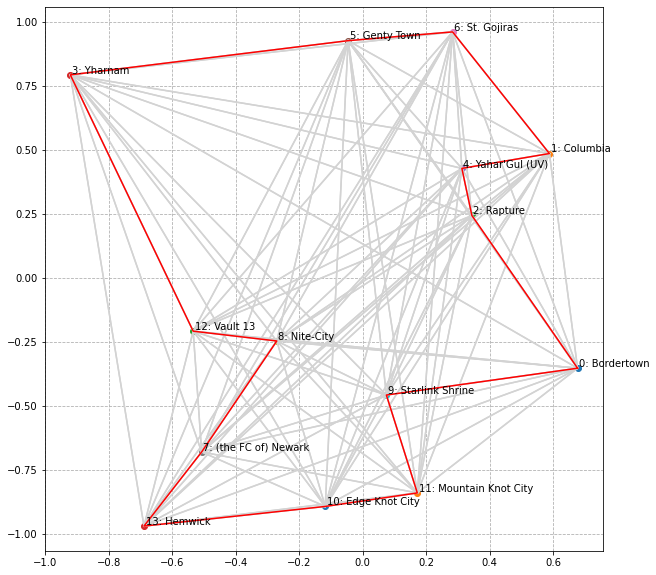

In [12]:
targetRoute = [  [t for t in towns if t[0]==ms][0]  for ms in minRoute  ]
tsp.plotTowns(towns, shortestTravel=targetRoute, plotSize=10)